# 基于词向量的英汉翻译——“火炬上的深度学习"下第一次作业

在这个作业中，你需要半独立地完成一个英文到中文的单词翻译器

本文件是集智AI学园http://campus.swarma.org 出品的“火炬上的深度学习”第VI课的配套源代码

In [1]:
# 加载必要的程序包
# PyTorch的程序包
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# 数值运算和绘图的程序包
import numpy as np
import matplotlib.pyplot as plt
import matplotlib


# 加载机器学习的软件包，主要为了词向量的二维可视化
from sklearn.decomposition import PCA

#加载Word2Vec的软件包
import gensim as gensim
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors
from gensim.models.word2vec import LineSentence

#加载正则表达式处理的包
import re

#在Notebook界面能够直接显示图形
%matplotlib inline

## 第一步：加载词向量

首先，让我们加载别人已经在大型语料库上训练好的词向量

In [2]:
# 加载中文词向量，下载地址为：链接：http://pan.baidu.com/s/1gePQAun 密码：kvtg
# 该中文词向量库是由尹相志提供，训练语料来源为：微博、人民日报、上海热线、汽车之家等，包含1366130个词向量
word_vectors = KeyedVectors.load_word2vec_format('vectors.bin', binary=True, unicode_errors='ignore')
print(len(word_vectors.vocab))

1366130


In [3]:
# 加载英文的词向量，下载地址为：http://nlp.stanford.edu/data/glove.6B.zip，解压后将glove.6B.100d.txt文件拷贝到与本notebook
# 文件一致的文件夹洗面。
f = open('glove.6B.100d.txt', 'r')
i = 1

# 将英文的词向量都存入如下的字典中
word_vectors_en = {}
with open('glove.6B.100d.txt') as f:
    for line in f:
        numbers = line.split()
        word = numbers[0]
        vectors = np.array([float(i) for i in numbers[1 : ]])
        word_vectors_en[word] = vectors
        i += 1
print(len(word_vectors_en))

400000


## 第二步：可视化同一组意思词在两种不同语言的词向量中的相互位置关系

In [4]:
# 中文的一二三四五列表
cn_list = {'一', '二', '三', '四', '五', '六', '七', '八', '九', '零'}
# 阿拉伯数字的12345列表
en_list = {'1', '2', '3', '4', '5', '6', '7', '8', '9', '0'}
# 英文数字的列表
en_list = {'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'zero'}

# 对应词向量都存入到列表中
cn_vectors = []  #中文的词向量列表
en_vectors = []  #英文的词向量列表
for w in cn_list:
    cn_vectors.append(word_vectors[w])
for w in en_list:
    en_vectors.append(word_vectors_en[w])

# 将这些词向量统一转化为矩阵
cn_vectors = np.array(cn_vectors)
en_vectors = np.array(en_vectors)

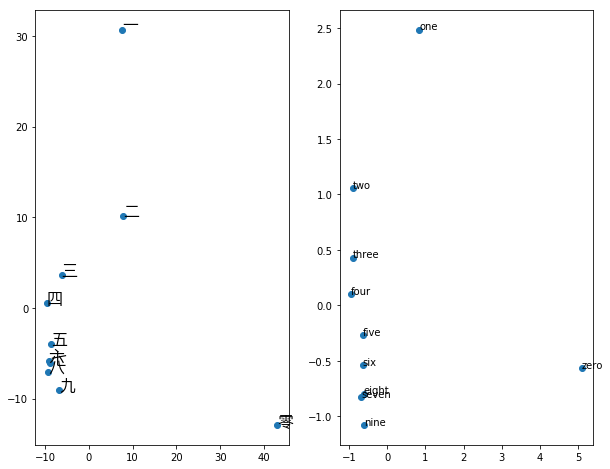

In [5]:
# 降维实现可视化
X_reduced = PCA(n_components=2).fit_transform(cn_vectors)
Y_reduced = PCA(n_components = 2).fit_transform(en_vectors)

# 绘制所有单词向量的二维空间投影
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 8))
ax1.plot(X_reduced[:, 0], X_reduced[:, 1], 'o')
ax2.plot(Y_reduced[:, 0], Y_reduced[:, 1], 'o')
zhfont1 = matplotlib.font_manager.FontProperties(fname='/System/Library/Fonts/PingFang.ttc', size=16)
for i, w in enumerate(cn_list):
    ax1.text(X_reduced[i, 0], X_reduced[i, 1], w, fontproperties = zhfont1, alpha = 1)
for i, w in enumerate(en_list):
    ax2.text(Y_reduced[i, 0], Y_reduced[i, 1], w, alpha = 1)

### 结论：可以看出，中文的一、二、等数字彼此之间的关系与英文的数字彼此之间的关系很类似

## 第三步：训练一个神经网络，输入一个英文单词的词向量，输出一个中文的词向量，并翻译为中文

首先，读入一个已经建立好的词典（dictionary.txt）。本词典是老师调用百度翻译的API，自动将一篇英文小说中的词汇逐个翻译为中文而得来的

我们一个个地载入词典，并查找对应的中文词向量，如果找得到，则放入original_words中，做为正式的训练集

In [6]:
original_words = []
with open('dictionary.txt', 'r') as f:
    dataset = []
    for line in f:
        itm = line.split('\t')
        eng = itm[0]
        chn = itm[1].strip()
        if eng in word_vectors_en and chn in word_vectors:
            data = word_vectors_en[eng]
            target = word_vectors[chn]
            # 将中英文词对做成数据集
            dataset.append([data, target])
            original_words.append([eng, chn])
print(len(dataset)) # 共有4962个单词做为总的数据集合

4962


In [7]:
# 建立训练集、测试集和校验集
# 训练集用来训练神经网络，更改网络的参数；校验集用来判断网络模型是否过拟合：当校验集的损失数值超过训练集的时候，即为过拟合
# 测试集用来检验模型的好坏
indx = np.random.permutation(range(len(dataset)))
dataset = [dataset[i] for i in indx]
original_words = [original_words[i] for i in indx]
train_size = 500
train_data = dataset[train_size:]
valid_data = dataset[train_size // 2 : train_size]
test_data = dataset[: train_size // 2]
test_words = original_words[: train_size // 2]


In [8]:
# 开始训练一个多层神经网络，将一个100维度的英文向量映射为200维度的中文词向量，隐含层节点为30

input_size = 100
output_size = 200
hidden_size = 30

# 新建一个神经网络，包含一个隐含层
model = torch.nn.Sequential(torch.nn.Linear(input_size, hidden_size),
                     torch.nn.Tanh(),
                     torch.nn.Linear(hidden_size, output_size)
                     )

# 构造损失函数
criterion = torch.nn.MSELoss()

# 构造优化器
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

# 总的循环周期
num_epoch = 100


#开始训练500次，每次对所有的数据都做循环
results = []
for epoch in range(num_epoch):
    train_loss = []
    for data in train_data:
        # 读入数据
        x = Variable(torch.FloatTensor(data[0])).unsqueeze(0)
        y = Variable(torch.FloatTensor(data[1])).unsqueeze(0)
        # 模型预测
        output = model(x)
        
        # 反向传播算法训练
        optimizer.zero_grad()
        loss = criterion(output, y)
        train_loss.append(loss.data.numpy()[0])
        loss.backward()
        optimizer.step()
    # 在校验集上测试一下效果
    valid_loss = []
    for data in valid_data:
        x = Variable(torch.FloatTensor(data[0])).unsqueeze(0)
        y = Variable(torch.FloatTensor(data[1])).unsqueeze(0)
        output = model(x)
        loss = criterion(output, y)
        valid_loss.append(loss.data.numpy()[0])
    results.append([np.mean(train_loss), np.mean(valid_loss)])
    print('{}轮，训练Loss: {:.2f}, 校验Loss: {:.2f}'.format(epoch, np.mean(train_loss), np.mean(valid_loss)))


0轮，训练Loss: 8.73, 校验Loss: 8.67
1轮，训练Loss: 8.33, 校验Loss: 8.39
2轮，训练Loss: 8.07, 校验Loss: 8.20
3轮，训练Loss: 7.91, 校验Loss: 8.09
4轮，训练Loss: 7.80, 校验Loss: 8.01
5轮，训练Loss: 7.71, 校验Loss: 7.94
6轮，训练Loss: 7.64, 校验Loss: 7.89
7轮，训练Loss: 7.58, 校验Loss: 7.84
8轮，训练Loss: 7.52, 校验Loss: 7.80
9轮，训练Loss: 7.48, 校验Loss: 7.76
10轮，训练Loss: 7.44, 校验Loss: 7.73
11轮，训练Loss: 7.40, 校验Loss: 7.70
12轮，训练Loss: 7.37, 校验Loss: 7.67
13轮，训练Loss: 7.34, 校验Loss: 7.65
14轮，训练Loss: 7.31, 校验Loss: 7.63
15轮，训练Loss: 7.29, 校验Loss: 7.62
16轮，训练Loss: 7.27, 校验Loss: 7.60
17轮，训练Loss: 7.25, 校验Loss: 7.59
18轮，训练Loss: 7.23, 校验Loss: 7.58
19轮，训练Loss: 7.21, 校验Loss: 7.57
20轮，训练Loss: 7.20, 校验Loss: 7.56
21轮，训练Loss: 7.19, 校验Loss: 7.55
22轮，训练Loss: 7.17, 校验Loss: 7.54
23轮，训练Loss: 7.16, 校验Loss: 7.53
24轮，训练Loss: 7.15, 校验Loss: 7.53
25轮，训练Loss: 7.14, 校验Loss: 7.52
26轮，训练Loss: 7.13, 校验Loss: 7.52
27轮，训练Loss: 7.12, 校验Loss: 7.51
28轮，训练Loss: 7.11, 校验Loss: 7.50
29轮，训练Loss: 7.10, 校验Loss: 7.50
30轮，训练Loss: 7.10, 校验Loss: 7.50
31轮，训练Loss: 7.09, 校验Loss: 7.49
32轮，训练Loss: 7.08, 

In [9]:
print(results)

[[8.7266426, 8.6740389], [8.3268251, 8.3886623], [8.0683985, 8.202508], [7.905406, 8.0897436], [7.7956738, 8.0083284], [7.7099166, 7.9420466], [7.6381788, 7.8857188], [7.5768032, 7.8371992], [7.523716, 7.7951794], [7.4773836, 7.7586598], [7.4366059, 7.7268205], [7.4004493, 7.6989765], [7.368196, 7.6745601], [7.3392806, 7.6530933], [7.3132496, 7.6341715], [7.2897229, 7.6174445], [7.2683773, 7.6026082], [7.2489338, 7.5893984], [7.2311549, 7.5775871], [7.2148409, 7.5669785], [7.199821, 7.5574064], [7.1859512, 7.5487275], [7.1731091, 7.5408211], [7.1611891, 7.533586], [7.1501012, 7.5269346], [7.1397662, 7.5207953], [7.1301146, 7.5151081], [7.1210866, 7.5098219], [7.112628, 7.5048952], [7.1046925, 7.5002937], [7.0972362, 7.4959884], [7.0902219, 7.4919543], [7.0836163, 7.4881706], [7.0773864, 7.4846182], [7.0715055, 7.4812832], [7.0659466, 7.4781499], [7.0606871, 7.4752059], [7.0557041, 7.4724393], [7.0509782, 7.469841], [7.0464926, 7.4673996], [7.0422297, 7.4651065], [7.0381751, 7.4629545],

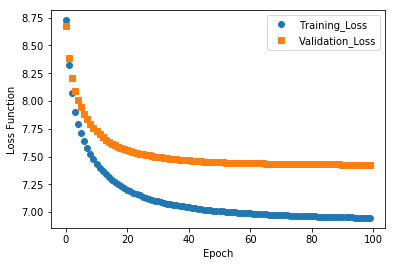

In [10]:
# 绘制图形
a = [i[0] for i in results]
b = [i[1] for i in results]
plt.plot(a, 'o', label = 'Training_Loss')
plt.plot(b, 's', label = 'Validation_Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Function')
plt.legend()

In [14]:
# 在测试集上验证准确度
# 检验标准有两个：一个是直接用预测的词和标准答案做全词匹配；另一个是做单字的匹配
exact_same = 0  #全词匹配数量
one_same = 0 #单字匹配数量
results = []
for i, data in enumerate(test_data):
    x = Variable(torch.FloatTensor(data[0])).unsqueeze(0)
    # 给出模型的输出
    output = model(x)
    output = output.squeeze().data.numpy()
    # 从中文词向量中找到与输出向量最相似的向量
    most_similar = word_vectors.wv.similar_by_vector(output, 1)
    # 将标准答案中的词与最相似的向量所对应的词打印出来
    results.append([original_words[i][1], most_similar[0][0]])
    
    # 全词匹配
    if original_words[i][1] == most_similar[0][0]:
        exact_same += 1
    # 某一个字匹配
    if list(set(list(original_words[i][1])) & set(list(most_similar[0][0]))) != []:
        one_same += 1
    
print("精确匹配率：{:.2f}".format(1.0 * exact_same / len(test_data)))
print('一字匹配率：{:.2f}'.format(1.0 * one_same / len(test_data)))
print(results)

精确匹配率：0.09
一字匹配率：0.17
[['罐', '木炭'], ['热忱', '感动'], ['码', '米'], ['服装', '款式'], ['肾脏', '损伤'], ['岩', '石块'], ['1978', '1966'], ['嗯', '呵呵'], ['来', '时候'], ['确实', '所以'], ['旁边', '边上'], ['戳', '打断'], ['甜蜜', '自然'], ['跳', '豆子'], ['禁止', '强迫'], ['计算', '脆弱'], ['你好', '小子'], ['转身', '看见'], ['眼泪', '哭泣'], ['再见', '我'], ['嗤之以鼻', '反驳'], ['天', '晚上'], ['原因', '损伤'], ['密封', '特制'], ['平方', '长廊'], ['绘制', '拼凑'], ['de', '女王'], ['上升', '侵蚀'], ['记者', '质问'], ['设置', '功能'], ['猎枪', '钳'], ['建筑', '建设'], ['随时', '慌乱'], ['杂志', 'sonnet'], ['软件', '应用'], ['无聊', '害怕'], ['主机', '生态系统'], ['补救', '可能'], ['信使', '语音'], ['极大', '重视'], ['妈妈', '我'], ['怀疑', '怀疑'], ['打', '一百'], ['最近', '相邻'], ['歌', '我'], ['成瘾者', '患者'], ['别处', '危险'], ['地狱', '恶魔'], ['门将', '顶上'], ['眼', '眼睛'], ['烂', '真的'], ['各种', '内容'], ['一些', '有'], ['敷衍了事', '敷衍'], ['标记', '纹路'], ['轮毂', '锈'], ['生产', '生产'], ['失控', '颤抖'], ['承认', '我'], ['食品', '食物'], ['的', '的'], ['易', '安静'], ['停止', '躲避'], ['丧失', '退回'], ['欢迎', '感谢'], ['希望', '恐惧'], ['手表', '照相机'], ['是', '我'], ['写', '写'], ['等待', '重新启动'], ['情况',